# Embedding-Based Venue Search & User Recommendation
_A demo for luna by Yiding Song (Vincent)._

<a href="https://colab.research.google.com/github/PerceptronV/Miscellaneous/blob/master/Venue_Embedding_and_User_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This is not an app. But I do have a neat algorithm.

My strength is not in IOS app dev, but I did make a neat ML-powered backend system. _In fact, I built a graph neural network from scratch that can find missing links in social networks for networking recommendations based on user preference._

In [1]:
# @markdown Install Dependencies & Import libraries

%pip install -q -U torch_geometric sentence-transformers

import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

import numpy as np
from scipy import stats
from torch_geometric.data import Data as GData
import torch_geometric.nn as gnn


torch.manual_seed(91387)

Note: you may need to restart the kernel to use updated packages.


c:\Users\vinny\Base\neurosymbolic-arc\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Part A - The Venue Search Problem

### Simulation Scenario


In [3]:
# @markdown Restaurant information
restaurant_names = ["Nine Tastes", "Hokkaido Ramen Santouka", "Tasty Burger", "Tatte Bakery", "El Jefe", "Joe's Pizza"]
restaurants = {
    "Nine Tastes": "Nine Tastes, 3.5/5, 80 reviews, #182 of 421 Restaurants in Cambridge, $$ - $$$, Thai, Vegetarian friendly, Vegan options",
    "Hokkaido Ramen Santouka": "Hokkaido Ramen Santouka, 4.5/5, 203 reviews, #8 of 421 Restaurants in Cambridge, $$ - $$$, Japanese, Asian, Soups",
    "Tasty Burger": "Tasty Burger, 3.5/5, 116 reviews, #20 of 54 Quick Bites in Cambridge, $, Quick Bites, American, Fast Food",
    "Tatte Bakery": "Tatte Bakery & Cafe | Third St, 4.5/5, 240 reviews, #2 of 38 Coffee & Tea in Cambridge, $$ - $$$, Bakeries, American, Cafe",
    "El Jefe": "El Jefe's Taqueria, 3.5/5, 14 reviews, #50 of 54 Quick Bites in Cambridge, $, Quick Bites, Mexican",
    "Joe's Pizza": "Joe's Pizza (Harvard Square), 3/5, 1 review, #51 of 54 Quick Bites in Cambridge, Quick Bites, Italian, Pizza"
}

In [4]:
user_names = ['Nico', 'Vincent', 'Jed', 'Elon', 'Mark']
users = {k: {} for k in user_names}

### User Preferences

In [5]:
# @markdown Nico
Text = "Can we do Thai food?" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.8 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Nico']['text'] = Text
users['Nico']['certainty'] = Certainty

In [6]:
# @markdown Vincent
Text = "I want some curry tonight." # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.65 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Vincent']['text'] = Text
users['Vincent']['certainty'] = Certainty

In [7]:
# @markdown Jed
Text = "Down for a nice grill place!" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.45 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Jed']['text'] = Text
users['Jed']['certainty'] = Certainty

In [8]:
# @markdown Elon
Text = "I want expensive sushi or coffee." # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.6 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Elon']['text'] = Text
users['Elon']['certainty'] = Certainty

In [9]:
# @markdown Mark
Text = "Something fast haha!" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.2 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Mark']['text'] = Text
users['Mark']['certainty'] = Certainty

### Initial Heatmap

c:\Users\vinny\Base\neurosymbolic-arc\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vinny\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\vinny\Base\neurosymbolic-arc\.venv\Lib\site-packages\transformers\models\bert

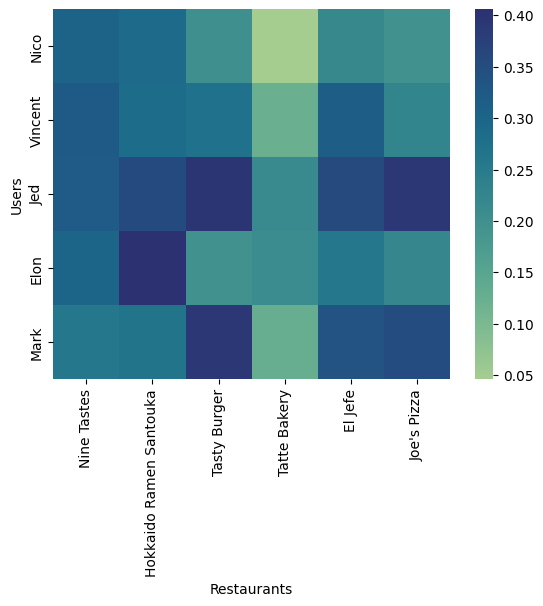

In [10]:
user_texts = ['Food: ' + users[n]['text'] for n in user_names]
user_certs = torch.tensor([users[n]['certainty'] for n in user_names])
restaurant_descriptions = ['Restaurant: ' + restaurants[n] for n in restaurant_names]

model = SentenceTransformer("all-MiniLM-L6-v2")

request_embeddings = model.encode(user_texts)
restaurant_embeddings = model.encode(restaurant_descriptions)
similarities = model.similarity(request_embeddings, restaurant_embeddings)

ax = sns.heatmap(similarities,
                 xticklabels=restaurant_names,
                 yticklabels=user_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
ax.set_ylabel("Users")
plt.show()

### Revalued Heatmap

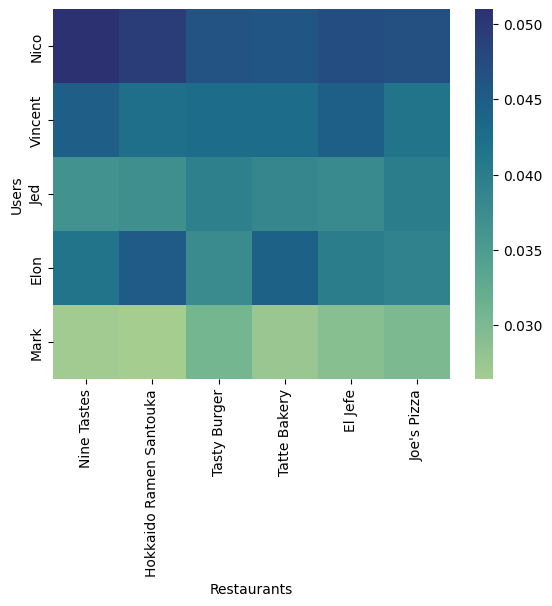

In [12]:
revalued = F.softmax(user_certs, dim=0).unsqueeze(dim=1) * F.softmax(similarities, dim=0)

ax = sns.heatmap(revalued,
                 xticklabels=restaurant_names,
                 yticklabels=user_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
ax.set_ylabel("Users")
plt.show()

### Final Scores

Restaurant with highest score is: Nine Tastes


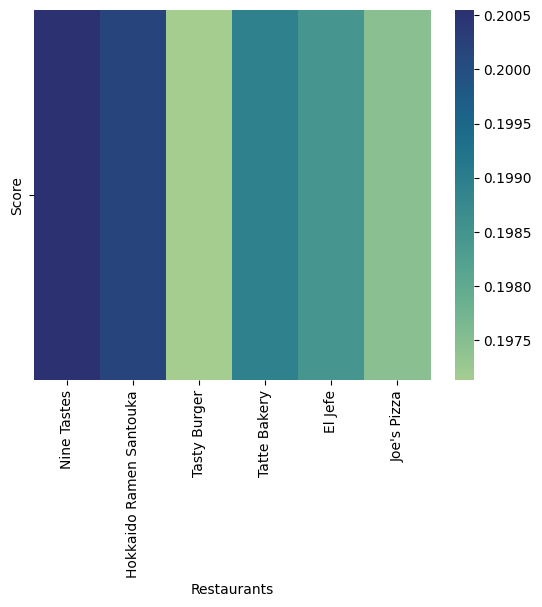

Nine Tastes: 0.2005445659160614
Hokkaido Ramen Santouka: 0.20016802847385406
Tasty Burger: 0.1971326321363449
Tatte Bakery: 0.19892911612987518
El Jefe: 0.19845718145370483
Joe's Pizza: 0.19747021794319153


In [13]:
scores = torch.sum(revalued, dim=0)
print(f'Restaurant with highest score is: {restaurant_names[torch.argmax(scores)]}')

ax = sns.heatmap(scores.unsqueeze(dim=0),
                 yticklabels=["Score"],
                 xticklabels=restaurant_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
plt.show()

for e, n in enumerate(restaurant_names):
    print(f'{n}: {scores[e]}')

## Part B - The User Recommendation Problem

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### 0) Problem Setup

> The central problem I am trying to investigate is this: given a user's existing connections, how can we best find other users that they would be interested in?

I built a mathematical model for this situation, and showed that a Graph Neural Network can effectively learn to uncover a user's preferences. Although the model is not perfect, it demonstrates convincing performance over other algorithmic baselines. The massive text block below describes my methodology, followed by some code.

The general workflow is:
1. Construct a _'ground truth'_ model of social interactions.
2. Sample from that ground truth to create a dataset with imperfect information.
3. See how a GNN can effectively learn from the imperfect data.

### 1) The Ground Truth Social Network Model & Dataset Construction

#### 1.1) Social Network Model
_What the GNN is trying to approximate._

Here I describe the model of social network interactions I assume to be the ground truth, and will subsequently teach a GNN to approximate. All numbers are vague here because we do not have real data, and this ground truth model may be very wrong. However, this model exists to provide a dataset for the GNN, so it doesn't matter whether the model itself is correct; the general point is to show that a GNN can approximate some model of user preferences, without prior information of the model details.

Let us instantiate a social network of $n$ users, where each user $u$ has an associated embedding vector $v_u$ of dimension $d$. Practically, such an embedding may be extracted from a user's bio or profile page using LLMs, or via other algorithmic graph theory metrics (e.g. eigenvector centrality). In any case, $v_u$ represents _who the user is_. Denote the $n \times d$ user embeddings matrix $E$.

A vanilla social media network model could then compute the similarity (e.g. cosine distance) between each user and suggest the ones with the highest score. However, each user has their own preferences and may not always wish to network with people similar to them; in fact, some people enjoy being pushed out of their comfort zone. To model this, we first sample a $d \times d$ user weights matrix $W$ from a normal distribuition. Then we specify hyperparameters $\alpha = 0.5, \beta = 1 - \alpha$, and calculate an overall $d \times d$ transformation matrix $T$:
$$T = \alpha I + \beta W$$
Using $T$, we calculate a user preferences matrix $P$:
$$P = ET$$

$P$ is a linear operator that acts on each user's embedding vector and maps it to another vector, which we will interpret as their _preference vector_ (i.e. the type of person they'd like to meet). The $\alpha I$ term in the equation above reflects the fact that users tend to want to meet people more similar to them, whilst the $\beta W$ term reflects the added value of meeting someone who is different in an interesting way.

We can then calculate an $n \times n$ scores matrix $S$ by computing the similarity between each user's preference vector and all other user's embedding vectors. Intuitively, this is basically computing $S = P E^T$ (but with some additional scaling factors).

Below, we carry out the above calculations using $n = 1000$, $d = 512$, and $W$ randomly sampled from a normal distribution.

In [3]:
num_users = 1000 # @param {"type":"integer","placeholder":"1000"}
dim_embed = 512 # @param {"type":"integer","placeholder":"512"}

In [4]:
def batch_similarity(a, b):
    norm_a = torch.norm(a, dim=1)
    norm_b = torch.norm(b, dim=1)
    sim = (a @ b.t()) / (2 * torch.outer(norm_a, norm_b)) + 0.5
    return sim

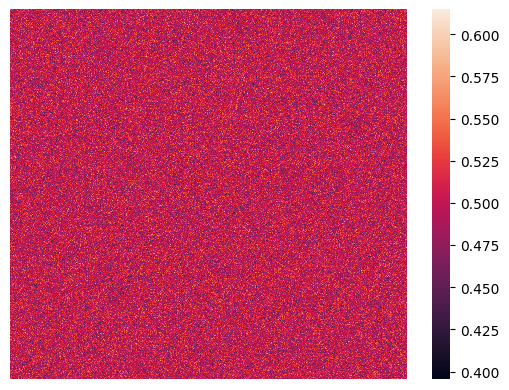

In [51]:
user_embeddings = torch.randn(num_users, dim_embed)
alpha = 0.5
beta = 1 - alpha
user_weights = alpha * torch.eye(dim_embed) + beta * torch.randn(dim_embed, dim_embed)
user_preferred = user_embeddings @ user_weights

scores = batch_similarity(user_preferred, user_embeddings)
_ = sns.heatmap(scores, xticklabels=[], yticklabels=[])

#### 1.2) Dataset Construction

Our objective is to get a GNN to predict the scores matrix $S$, which we can then exploit to give user recommendations for who to meet. However, asking a user to rate every other user is infeasible, not least because each user has only met a very tiny subset of other users, and may choose to rate even fewer of them. Practically, what we can probably implement is to ask each user to rate their satisfaction after events, and use that to estimate how much they enjoy spending time with a _very tiny_ subset of other users. The lack of data makes the problem challenging, but not intractable. As you will see below, in our setup, the GNN only has roughly 25 ratings from each user to learn from.

Anyways, in our social network, we expect connections to form where the score is greater than some threshold $\tau$. Therefore, we can build a $n \times n$ _connections matrix_ $C$ which has entry 1 where $S > \tau$ and 0 everywhere else. This matrix may be interpreted as the _adjacency matrix_ of a directed graph. The direction is interpreted like this: if there is an edge from user $u$ to user $v$, then we assume user $u$ has rated their interactions with user $v$.

Of course, in the real world, users are limited in their knowledge of other users. Here, I asume that they have only interacted with about $70\%$ (controlled by the variable `keep`) of all other users whose scores exceed threshold $\tau$. This is implemented below, where I only keep 70% of above-threshold connections for the training dataset.

In other words, we have built a dataset where the GNN only has access to imperfect information of ratings, seeing only user ratings for other similar users that they already know.

In [ ]:
threshold = 0.54 # @param {"type":"slider","min":0,"max":1,"step":0.01}
keep = 0.7 # @param {"type":"slider","min":0,"max":1,"step":0.01}

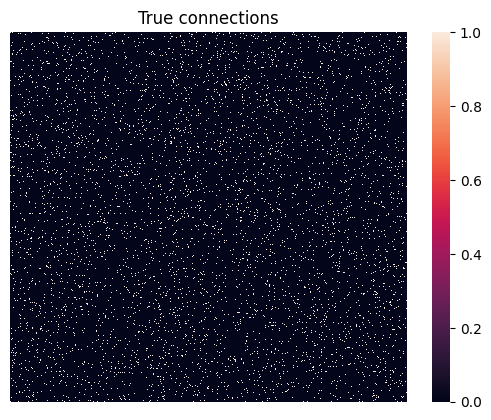

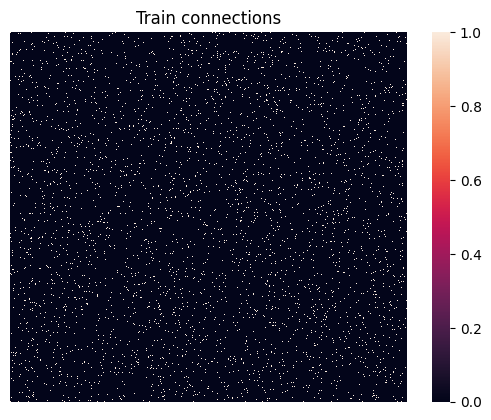

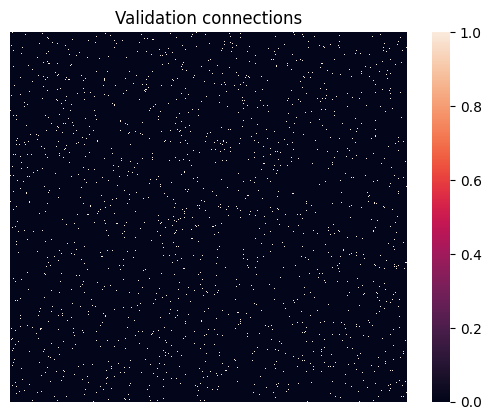

# edges for true connections: 35220
# edges for train connections: 24596
# edges for validation connections: 10624


In [52]:
connections = torch.where(scores > threshold, 1, 0)

invnorm = stats.norm.ppf(keep)
noise = torch.where(torch.randn(num_users, num_users)<invnorm, 1, 0)
train_connections = connections * noise
val_connections = connections * (1 - train_connections)

_ = sns.heatmap(connections, xticklabels=[], yticklabels=[])
plt.title("True connections")
plt.show()

_ = sns.heatmap(train_connections, xticklabels=[], yticklabels=[])
plt.title("Train connections")
plt.show()

_ = sns.heatmap(val_connections, xticklabels=[], yticklabels=[])
plt.title("Validation connections")
plt.show()

print(f"# edges for true connections: {connections.sum().item()}")
print(f"# edges for train connections: {train_connections.sum().item()}")
print(f"# edges for validation connections: {val_connections.sum().item()}")

In [53]:
edgelist = train_connections.nonzero().t().contiguous()
data = GData(x=user_embeddings,
             y=scores.flatten(),
             train_mask=train_connections.flatten().bool(),
             val_mask=val_connections.flatten().bool(),
             edge_index=edgelist).to(device)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 1000
Number of edges: 24596
Has isolated nodes: False
Has self-loops: True
Is undirected: False


### 2) Graph Convolutional Neural Network

Here we build our graph neural network. It takes in a social network graph with an embedding for each user. Then it performs multiple rounds of graph convolution, and tries to give an estimate for users' preference vectors $P'$.

We train the GNN for 2000 epochs, where in each epoch, it learns to approximate the user ratings it has access to. Interestingly, the model learns very slowly the first few epochs, and even seems to overfit; then it begins to grok and generalise.

In [54]:
device_user_embeddings = user_embeddings.clone().to(device)

class GCN(torch.nn.Module):
    def __init__(self, dim_embed, dim_hidden=512):
        super().__init__()
        self.conv1 = gnn.GCNConv(dim_embed, dim_hidden)
        self.conv2 = gnn.GCNConv(dim_hidden, dim_hidden)
        self.conv3 = gnn.GCNConv(dim_hidden, dim_embed)

    def forward(self, x, edge_index):
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        h = F.relu(self.conv3(h, edge_index))
        out = batch_similarity(h, device_user_embeddings)
        return out, h

In [55]:
model = GCN(dim_embed).to(device)
print(model)

GCN(
  (conv1): GCNConv(512, 512)
  (conv2): GCNConv(512, 512)
  (conv3): GCNConv(512, 512)
)


In [56]:
num_epochs = 2000
every = 100
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    out, _ = model(data.x, data.edge_index)
    pred = out.flatten()
    loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss

for epoch in range(num_epochs):
    loss = train(data)
    if epoch % every == every - 1:
        out, _ = model(data.x, data.edge_index)
        pred = out.flatten()
        val_loss = loss_fn(pred[data.val_mask], data.y[data.val_mask])

        print(f'.\nEpoch {epoch+1}, Train: {loss:.5f}, Val: {val_loss:.5f}')
    else:
        print('.', end='')

....................................................................................................
Epoch 100, Train: 0.00201, Val: 0.00200
....................................................................................................
Epoch 200, Train: 0.00201, Val: 0.00200
....................................................................................................
Epoch 300, Train: 0.00201, Val: 0.00200
....................................................................................................
Epoch 400, Train: 0.00200, Val: 0.00200
....................................................................................................
Epoch 500, Train: 0.00193, Val: 0.00200
....................................................................................................
Epoch 600, Train: 0.00182, Val: 0.00201
....................................................................................................
Epoch 700, Train: 0.00161, Val: 0.00201
.............

Since the GNN only has access to ratings above threshold $\tau$, we check that the full range of the GNN's ratings can extrapolate and match that of ground truth user scores. It does.

In [57]:
out, h = model(data.x, data.edge_index)
pred = out.cpu().detach()
print(f'Pred min: {pred.min():.4f}, max: {pred.max():.4f}.')
print(f'True min: {scores.min():.4f}, max: {scores.max():.4f}.')

Pred min: 0.4029, max: 0.6068.
True min: 0.3957, max: 0.6150.


### 3) Evaluation

Here we test the GNN's predicted user ratings against our ground truth user ratings (from the scores matrix $S$). We filter out the training set to avoid contaminating the results, and compute Pearson's Correlation Coefficient. We also check for the percentage of connections that the GNN successfully recovers from the training set out of all the ground truth connections.

We give further data for the same metrics, but using:
1. A cosine-similarity-based baseline.
2. A structured model using the same model as the ground truth model above, but different random weights.
3. A random baseline.

The GNN model outperforms the other comparison models quite convincingly.

In [58]:
def eval(name, pred):
    test_scores = scores.flatten()[(1-train_connections).flatten().bool()]
    test_pred = pred.flatten()[(1-train_connections).flatten().bool()]

    r = stats.pearsonr(test_scores, test_pred)
    print(f'{name} pearson r: {r[0]:.4f}')

    discrete_pred = torch.where(pred > threshold, 1, 0)
    diff = (discrete_pred - connections) * (1 - train_connections)
    print(f'{name} dp-c: {torch.unique(diff, return_counts=True)}')

    recovered = torch.sum(discrete_pred * connections * (1 - train_connections))
    lost = torch.sum(connections) - torch.sum(train_connections)
    print(f"{name} lost connections recovered: {recovered*100/lost:.4f}%\n")

In [64]:
eval('GNN Model', pred)
eval('Baseline', batch_similarity(user_embeddings, user_embeddings))
nw = 0.7 * torch.eye(dim_embed) + 0.3 * torch.randn(dim_embed, dim_embed)
eval('Random structured', batch_similarity(user_embeddings, user_embeddings @ nw))
eval('Random', batch_similarity(user_embeddings, torch.randn(num_users, dim_embed)))

GNN Model pearson r: 0.1256
GNN Model dp-c: (tensor([-1,  0,  1]), tensor([  9742, 946281,  43977]))
GNN Model lost connections recovered: 8.3020%

Baseline pearson r: 0.0453
Baseline dp-c: (tensor([-1,  0,  1]), tensor([ 10174, 955493,  34333]))
Baseline lost connections recovered: 4.2357%

Random structured pearson r: 0.0041
Random structured dp-c: (tensor([-1,  0,  1]), tensor([ 10236, 955130,  34634]))
Random structured lost connections recovered: 3.6521%

Random pearson r: 0.0029
Random dp-c: (tensor([-1,  0,  1]), tensor([ 10245, 955935,  33820]))
Random lost connections recovered: 3.5674%

